In [1]:
import numpy as np
import gizmo_analysis as gizmo
import utilities as ut
import matplotlib
from matplotlib import pyplot as plt
import astropy
from IPython.display import clear_output
import matplotlib.ticker as ticker

from datetime import date
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from astropy.io import ascii

from scipy import optimize, stats
import emcee
import corner

plt.rcParams["font.family"] = "Serif"
plt.rcParams.update({'font.size': 13, 'font.weight' : 100})

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

import imageio
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import kde

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
print(matplotlib.cm)
today = date.today()

# dd/mm/YY
d1 = today.strftime("%d_%m_%Y")
print("d1 =", d1)

<module 'matplotlib.cm' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\cm.py'>
d1 = 28_05_2021


In [3]:
# Dictionary with galaxy name and corresponding local directory containing the HDF5, snapshot_times.txt, etc.
# - for ease of access. 

dirs = { 'm11b' : 'D:\Data\m11b_res2100_v2' , 'm11q' : 'D:\Data\m11q_res880', 
       'm11h' : 'D:\Data\m11h_res880', 'm10v' : 'D:\Data\m10v_res250', 'm11d' : 'D:\Data\m11d_res7100',
       'm12i' : 'D:\Data\m12i_res7100', 'm12i_old' : 'D:\College Year 2\Research Total\Mw1\main',
       'm12i_low' : 'D:\Data\m12i_res57000', 'm11b_new' : 'D:\Data\m11bfin' }

# Function below loads the snapshot 600 from the directory that it has been assigned to. Simply use the galaxy's name
# in lowercase to get your data (provided that the directory is properly set)

def load():
    galaxy = 'm11b_new'
    
    print('LOADING GALAXY: ' + galaxy + " in " + dirs[galaxy])
    
    part = gizmo.io.Read.read_snapshots(['star'], 'redshift', 0, simulation_directory=dirs[galaxy],
                                       assign_formation_coordinates = True, assign_hosts='mass', 
                                        assign_hosts_rotation=True)
    return part, galaxy

def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

bbr = cmap_map(lambda x: 1-x, matplotlib.cm.bwr)  # the "transformation" = 1-x


part, galaxy = load()


species='star'
mass = part[species].prop('mass')
age = part[species].prop('age')
feh  = part[species].prop('metallicity.fe')
sife = part[species].prop('metallicity.si - metallicity.fe')
cafe = part[species].prop('metallicity.ca - metallicity.fe') 
ofe = part[species].prop('metallicity.o - metallicity.fe') 
form = part[species].prop('host.distance.principal.spherical')
ids = part[species].prop('id')

#Rxy = part[species].prop('host.distance.principal.cylindrical')[:,0]
#z = part[species].prop('host.distance.principal.cylindrical')[:,1]
mgfe = part[species].prop('metallicity.mg - metallicity.fe')

x = part[species].prop('host.distance.principal')[:,0]
y = part[species].prop('host.distance.principal')[:,1]
z = part[species].prop('host.distance.principal')[:,2]

R = part[species].prop('host.distance.principal.spherical')[:,0]
phi = part[species].prop('host.distance.principal.cylindrical')[:,2]*(180.0/np.pi)
Rform = form[:,0]

LOADING GALAXY: m11b_new in D:\Data\m11bfin

# in utilities.simulation.Snapshot():
* reading:  D:\Data\m11bfin/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  D:\Data\m11bfin/output\snapshot_600.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 22374200 particles
    dark2     (id = 2): 19623813 particles
    gas       (id = 0): 22336883 particles
    star      (id = 4): 37213 particles
    blackhole (id = 5): 0 particles

* reading species: ['star']
* reading particles from:
    D:\Data\m11bfin/output\snapshot_600.hdf5

! cannot find MUSIC config file:  D:\Data\m11bfin/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA):
  assuming omega_baryon = 0.0455
  assuming sigma_8 = 0.807
  assuming n_s = 0.961

* checking sanity of particle properties


# in utilities.particle.get_center_positions():
* assigning position for 1 cen

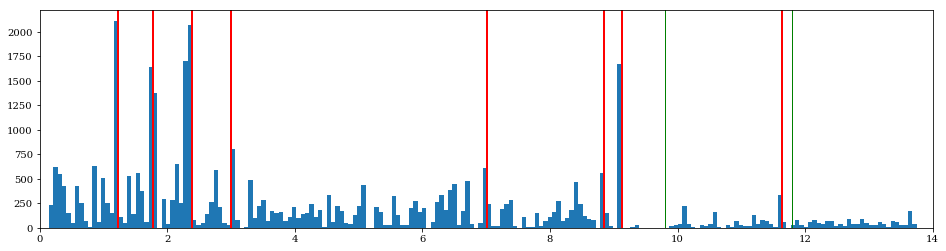

In [4]:
plt.figure(figsize=(16,4))
plot = plt.hist(13.79874-age, bins = 200)
plt.xlim(0,14)

needed = [31, 68, 72, 99, 158, 167, 176, 184]

for i in range(0, len(needed)):
    needed[i] = 200 - needed[i]

values = []

for i in range(130, len(plot[0]) - 1):
    if(plot[0][i-1] <= plot[0][i] and plot[0][i] >= plot[0][i+1]):
        values.append(i)

ages = []
for i in needed:
    plt.axvline(plot[1][i], color ='red', lw = 2)
    ages.append(plot[1][i])

plt.axvline(13.79874-2, c = 'g', lw = 1)
plt.axvline(13.79874-4, c = 'g', lw = 1)

plt.show()

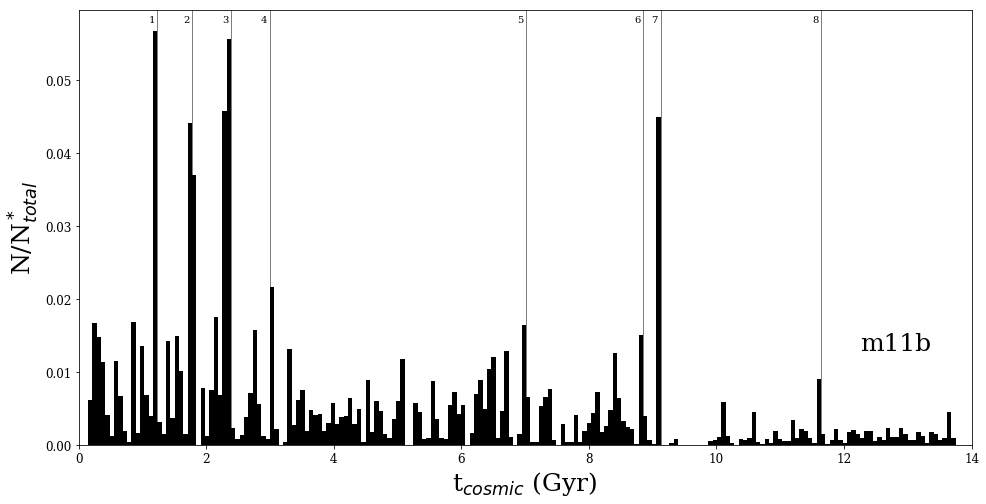

In [5]:
width = 0.05
weights = np.ones_like(13.798-age)/float(len(13.798-age))

plt.figure(figsize=(16,8))
plt.xlabel(r"t$_{cosmic}$ (Gyr)", size = 25)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.ylabel(r"N/N$^*_{total}$", size = 25)
plt.text(12.25, .013, "m11b", size = 25)
plot = plt.hist(13.79874 - age, bins = 200, weights = weights, color = 'black')
plt.xlim(0,14)

agers = [] # need to initialize this as ages is appended in a later loop

count = 2

for i in needed:
    plt.axvline(plot[1][i], color ='black', lw = 0.5)
    plt.text(plot[1][i] - .14, .058, str(10-count), size = 10, rotation = 0)
    agers.append(plot[1][i])
    count += 1
    #print(np.average(age[np.where( (age < plot[1][i] + 0.1) & (age > plot[1][i] - 0.1))])) #prints avg age in bin

plt.show()

In [6]:
ages = agers[::-1] 

ages = np.array(ages)
ua = 13.79874 # time at last snapshot, found from snapshot_times.text


# 
ages[0] = (ua - ages[0] + 0.03)
ages[1] = (ua - ages[1] )
ages[2] = (ua - ages[2] + 0.08 )
ages[3] = (ua - ages[3] - 0.005)
ages[4] = (ua - ages[4]) 
ages[5] = (ua - ages[5] )
ages[6] = (ua - ages[6] - 0.025) 
ages[7] = (ua - ages[7] )

print(ages[2])

if(ages[2] < 11):
    print("""ERROR""")
    print(ages[2])

desired = [0,0,0,2,6]

11.491396936682856


In [35]:
indices = []
indices2 = []
rfinds = []
rfinds2 = []
width = 0.1
countsarr = []
xbinsarr = []
ybinsarr = []
imagearr = []
widths = [0.1,0.15,0.06,0.1,0.15,0.05,0.045,0.05,0.1]



cmap1 = 'Spectral'

# For regions with significant Rform

ln = [0.29,0.55,0.81]
lefts = [ln[0],ln[1]-.125,ln[2]-.125,ln[0]-.125,ln[1]-.125,ln[2]-.125,ln[0]-.125,ln[1]-.125,ln[2]-0.125]
        #   1       2           3         4          5          6          7            8         9
lefts = np.array(lefts)

bottoms = [.7,.7,.7,.32,.32,.32,.15,.15,.15]

irange = 8

for i in range(0,irange):
    bottoms[i] = bottoms[i] - .1 #Adjust bottoms

xarray = np.linspace(-5,0)

for i in range(0,irange):
    indices.append(np.where( (age >= ages[i]-widths[i]) & (age <= ages[i] + widths[i]) ))
                            #& (Rform < 100)))
    
    indices2.append(np.where( (age >= ages[i]-widths[i]) & (age <= ages[i] + widths[i]) ))
                             #& (Rform < 20)))
    

ilist = desired
if(len(ilist) < 6):
    ilist.insert(0,0)

print(ilist)

for i in range(1,1):
   
    print("i: " + str(i))
    print("ilist[i]: " + str(ilist[i]))
    print("AGE: " + str(ages[i]))
    print("AGE - w: " + str(ages[i] - width))
    print("AGE + w: " + str(ages[i] + width))
    print("Tform : [" + str(round(ages[i] - width,2)) + "," + str(round(ages[i] + width,2)) + "]")
    print("--------------------------------")
    
    bottomt = 13.798974-np.min(age[indices[ilist[i]]]) # Not 'ages' because this is the full list of ages - 
    topt = 13.798974-np.max(age[indices[ilist[i]]]) # - we select here the oldest and youngest stars in the galaxy.

ValueError: operands could not be broadcast together with shapes (37213,) (32505,) 

In [ ]:

nbins=300 
xs = []
ys = []
zs = []
ks = []
xis = []
yis = []


# create data
for i in range(0,3):
    xs.append(feh[indices[ilist[i+3]]]) # Why is this i + 3? See "ilist" above, only relevant for m11b analysis.
    ys.append(mgfe[indices[ilist[i+3]]]) # In principle, this shouldn't need to comb a list with any offset. 
    
    k = kde.gaussian_kde([xs[i],ys[i]])

    xi, yi = np.mgrid[xs[i].min():xs[i].max():nbins*1j, ys[i].min():ys[i].max()+0.1:nbins*1j]
    xis.append(xi)
    yis.append(yi)
    zs.append(k(np.vstack([xi.flatten(), yi.flatten()])))

ValueError: cannot reshape array of size 32505 into shape (300,300)

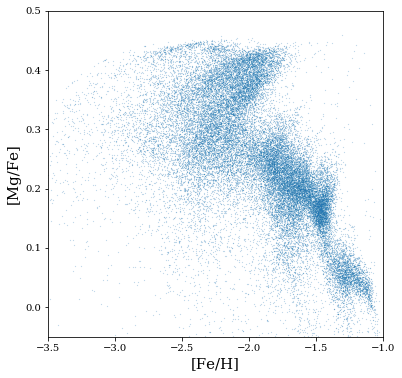

In [36]:
# Make the plot
plt.figure(figsize = (6,6))
plt.scatter(feh,mgfe,s = 0.01)

plt.ylabel("[Mg/Fe]", size = 15)
plt.xlabel("[Fe/H]",size=15)
plt.xlim(-3.5,-1)
plt.ylim(-0.05,0.5)
#plt.savefig("Goodluckduck.png", dpi = 300, bbox_inches = "tight")

ao0 = plt.contour(xis[0], yis[0], zs[0].reshape(xis[0].shape), levels = 9, alpha = 0.5)
ao1 = plt.contour(xis[1], yis[1], zs[1].reshape(xis[1].shape), levels = 8, alpha = 0.5)
ao2 = plt.contour(xis[2], yis[2], zs[2].reshape(xis[2].shape), levels = 10, alpha = 0.5)

plt.show()
# Change color palette
#plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Greens_r)
#plt.show()

In [ ]:
indices = []
indices2 = []
rfinds = []
rfinds2 = []
width = 0.1
countsarr = []
xbinsarr = []
ybinsarr = []
imagearr = []
widths = [0.07,0.15,0.045,0.1,0.15,0.05,0.056,0.05,0.1]

cmap1 = 'Spectral'

# For regions with significant Rform

ln = [0.29,0.55,0.81]
lefts = [ln[0],ln[1]-.125,ln[2]-.125,ln[0]-.125,ln[1]-.125,ln[2]-.125,ln[0]-.125,ln[1]-.125,ln[2]-0.125]
        #   1       2           3         4          5          6          7            8         9
lefts = np.array(lefts)

bottoms = [.7,.7,.7,.32,.32,.32,.15,.15,.15]

irange = 8

for i in range(0,irange):
    bottoms[i] = bottoms[i] - .1 #Adjust bottoms

xarray = np.linspace(-5,0)

for i in range(0,irange):
    indices.append(np.where( (age >= ages[i]-widths[i]) & (age <= ages[i] + widths[i]) 
                            & (Rform < 100)))
    

In [ ]:
i = 5
plt.scatter(feh, mgfe, c = age, s = 0.1)
plt.scatter(feh[indices[ilist[i]]], mgfe[indices[ilist[i]]], s = 0.1, c = 'black',
                cmap = cmap1)
plt.ylim(0,0.45)
plt.xlim(-3.5,-1)

print(len(mgfe[indices[ilist[i]]]))

print(ilist[5])
i = 5
idloi = ids[np.isin(ids,ids[indices[i]])]
idsoi = ids[indices[ilist[i]]]

In [ ]:
galaxy = 'm11b_new'

def load(snap): 
    print('LOADING GALAXY: ' + galaxy + " in " + dirs[galaxy])
    
    part = gizmo.io.Read.read_snapshots(['star', 'gas','dark'], 'snapshot', int(snap), assign_hosts = 'mass', simulation_directory=dirs[galaxy],
                                       assign_hosts_rotation=True, assign_formation_coordinates = False)
    return part

relevant_snapshots = [395,396,397] #This is when the gas falls in and new stars form. 

#empty lists for all variables we will look into
mass_s, mass_g, mass_d = ([] for i in range(3)) 

part = load(397)

In [37]:
mass_s, mass_g, mass_d, r_s, r_g, r_d = ([] for i in range(6)) 
mass_s.append(part['star'].prop('mass'))
mass_g.append(part['gas'].prop('mass'))
mass_d.append(part['dark'].prop('mass'))
r_s.append(part['star'].prop('host.distance.principal'))

In [38]:
print((np.sum(mass_s) + np.sum(mass_g) + np.sum(mass_d))/1e11)

2.80079958016


In [39]:
galaxy = 'm11b_new'

def load(snap): 
    print('LOADING GALAXY: ' + galaxy + " in " + dirs[galaxy])
    
    part = gizmo.io.Read.read_snapshots(['star', 'gas'], 'snapshot', int(snap), assign_hosts = 'mass', simulation_directory=dirs[galaxy],
                                       assign_hosts_rotation=True, assign_formation_coordinates = False)
    return part

relevant_snapshots = [395,396,397] #This is when the gas falls in and new stars form. 

#empty lists for all variables we will look into
ages, fehs, fehgs, mgfes, idss, idgs, velss, velgs, xs, ys, zs, xgs, ygs, zgs, hvels = ([] for i in range(15)) 

for i in range(0,3):
    part = load(relevant_snapshots[i])
    hvels.append(part.host['velocity']) #halo velocities - necessary for arrow/quiver plots. To find particle velocity 
#                                        for a given reference frame, find [hvel - particle_velocity]
    
    species='star'
    ages.append(part[species].prop('age'))
    fehs.append(part[species].prop('metallicity.fe'))
    idss.append(part[species].prop('id'))
    velss.append(part[species].prop('velocity'))
    mgfes.append(part[species].prop('metallicity.mg - metallicity.fe'))
    xs.append(part[species].prop('host.distance.principal')[:,0])
    ys.append(part[species].prop('host.distance.principal')[:,1])
    zs.append(part[species].prop('host.distance.principal')[:,2])
    
    fehgs.append(part['gas'].prop('metallicity.fe'))
    xgs.append(part['gas'].prop('host.distance.principal')[:,0])
    ygs.append(part['gas'].prop('host.distance.principal')[:,1])
    zgs.append(part['gas'].prop('host.distance.principal')[:,2])
    idgs.append(part['gas'].prop('id'))    
    velgs.append(part['gas'].prop('velocity'))

LOADING GALAXY: m11b_new in D:\Data\m11bfin

# in utilities.simulation.Snapshot():
* reading:  D:\Data\m11bfin/snapshot_times.txt

  using snapshot index = 395, redshift = 0.454


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  D:\Data\m11bfin/output\snapshot_395.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 22374200 particles
    dark2     (id = 2): 19623813 particles
    gas       (id = 0): 22341620 particles
    star      (id = 4): 32505 particles
    blackhole (id = 5): 0 particles

* reading species: ['star', 'gas']
* reading particles from:
    D:\Data\m11bfin/output\snapshot_395.hdf5

! cannot find MUSIC config file:  D:\Data\m11bfin/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA):
  assuming omega_baryon = 0.0455
  assuming sigma_8 = 0.807
  assuming n_s = 0.961

* checking sanity of particle properties
! warning: gas temperature [min, max] = [2.810, 7.485e6]


# in utilities.particle.get_center_

In [40]:
rss = []
rgs = []
for i in range(0,3):
    rss.append(np.sqrt((xs[i]**2) + (ys[i]**2) + (zs[i]**2)))
    rgs.append(np.sqrt((xgs[i]**2) + (ygs[i]**2) + (zgs[i]**2)))

In [41]:
print(len(xgs[i][np.isin(idgs[i],idsoi)]))

0


In [42]:
def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki, key in enumerate(('red','green','blue')):
        cdict[key] = [(indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in range(N+1)]
    # Return colormap object.
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

spec_disc = cmap_discretize(matplotlib.cm.Spectral, 9)
gnu = cmap_discretize(matplotlib.cm.Spectral, 5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error 

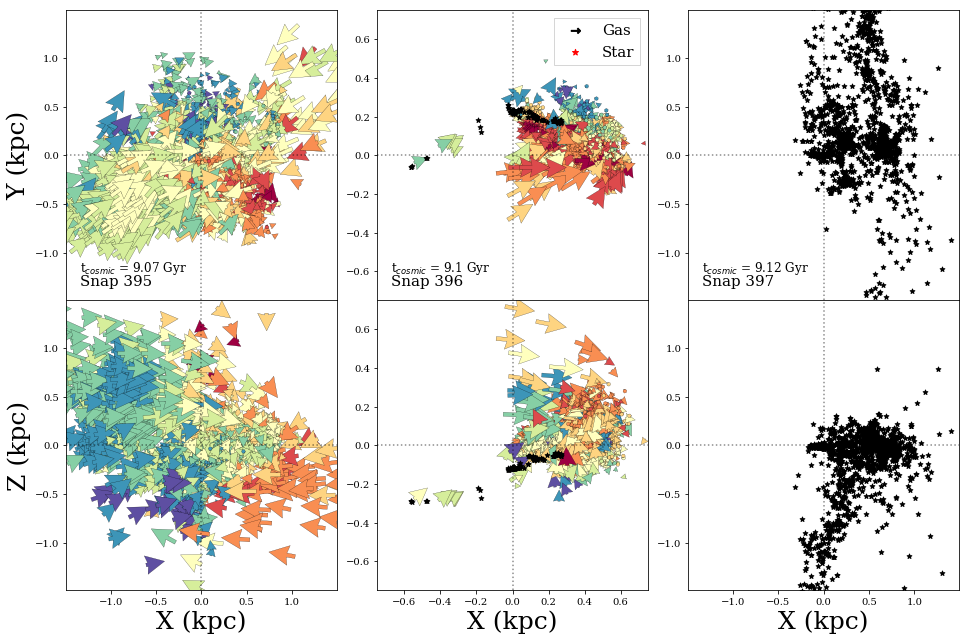

In [43]:
fig, ( (ax1, ax2, ax3), (ax4, ax5, ax6) ) = plt.subplots(nrows = 2, ncols = 3, sharex = False, sharey = False,
                                                                         figsize = (16,10.67))
axes = [ax1,ax2,ax3,ax4,ax5,ax6]
boxsizes = [1.49,0.75,1.49]
particle_size = ps = 25
bbr = spec_disc # COLORMAP HERE
alpha_l = 0.45
times = [9.07, 9.10, 9.12]

headw = 5
arrscale = 2.5

for i in range(0, 3):
    cgrad = ages[i][np.isin(idss[i],idsoi)]
    indg = [np.isin(idgs[i],idsoi)]
    indg0 = [np.isin(idgs[0],idsoi)]
    indst = [np.isin(idss[i],idsoi)]
    
    #vgx = velgs[0][:,0][indg]-hvels[0][0][0]
    #vgy = velgs[0][:,1][indg]-hvels[0][0][1]
    #vgz = velgs[0][:,2][indg]-hvels[0][0][2]
    
    ############## THE FOLLOWING CODE IS FOR GENERATING AN INSET COLORBAR ############
    #
    #ind = indg
    #counts1,xbins1,ybins1,image1 = plt.hist2d(vgx, vgy, bins = [100,100])
    #
    ##mean age for bins of stars in mgfe vs feh space
    #mean_age1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(vgx, vgy, 
    #                                                                    vgz, 'mean', bins= [100,100])
    #
    ##masks below cuts out where there are fewer stars than a particular threshold
    #m1 = np.ma.masked_where(counts1 < 1,  mean_age1)
    #im = ax1.imshow(m1.transpose(), interpolation='nearest', origin='low', 
    #                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = bbr, aspect='auto', 
    #                vmin=np.min(vgz), vmax=np.max(vgz))
    #ax1.clear()
    #
    #cbar_ax = fig.add_axes([ 0.14, 0.54, 0.145, 0.02]) #left, bottom, width, height  # vertically oriented colorbar
    #
    #cb = fig.colorbar(im, cax=cbar_ax,  orientation = 'horizontal')
    ##cb.ax.yaxis.set_ticks_position("right")
    ##cb.ax.set_yticklabels(['0 Gyr', '13.8 Gyr'], fontweight = 15) # Used to make custom labels on the tick marks themselves
    #cb.ax.set_title(r"v$_{z}$ (km/s)")
    ##cb.ax.yaxis.set_label_position("left")
    #
    ############## THE ABOVE CODE IS FOR GENERATING AN INSET COLORBAR ############
    
    #plotting gas particles
    #axes[i].scatter(xgs[i][indg], ygs[i][indg], s = ps, c = 'black', label = 'Gas')
    #axes[i+3].scatter(xgs[i][indg], zgs[i][indg], s = ps, c = 'black')
    
    axes[i].quiver(xgs[i][indg], ygs[i][indg], velgs[i][:,0][indg]-hvels[i][0][0], 
           velgs[i][:,1][indg]-hvels[i][0][1], velgs[i][:,2][indg]-hvels[i][0][2], 
                   pivot = 'tail', scale = arrscale, headwidth = headw, units = 'dots', cmap = bbr,
                  width = 4, edgecolor = 'black', linewidths = 0.2)
    
    axes[i+3].quiver(xgs[i][indg], zgs[i][indg], velgs[i][:,0][indg]-hvels[i][0][0], 
           velgs[i][:,2][indg]-hvels[i][0][2], velgs[i][:,1][indg]-hvels[i][0][1], 
                   pivot = 'tail', scale = arrscale, headwidth = headw, units = 'dots', cmap = bbr,
                  width = 4, edgecolor = 'black', linewidths = 0.2) 
  
    #plotting star particles 
    axes[i].scatter(xs[i][np.isin(idss[i],idsoi)], ys[i][np.isin(idss[i],idsoi)], s = ps, c = 'black', cmap = bbr,
                    marker = "*")
    
    axes[i+3].scatter(xs[i][np.isin(idss[i],idsoi)], zs[i][np.isin(idss[i],idsoi)], s = ps, c = 'black', cmap = bbr,
                      marker = "*")
    
    #plot adjusments
    axes[i].text(-boxsizes[i]*.9,-boxsizes[i]*.9, "Snap " + str(relevant_snapshots[i]), size = 15)
    axes[i].text(-boxsizes[i]*.9,-boxsizes[i]*.8, r"t$_{cosmic}$ = " + str(times[i]) + " Gyr", size = 12)
    axes[i+3].set_xlim(-boxsizes[i],boxsizes[i])
    axes[i+3].set_ylim(-boxsizes[i],boxsizes[i])
    axes[i].set_xlim(-boxsizes[i],boxsizes[i])
    axes[i].set_ylim(-boxsizes[i],boxsizes[i])
    xticks = axes[i].xaxis.get_majorticklabels()
    yticks = axes[i].yaxis.get_majorticklabels()
    plt.setp(xticks, visible=False)
    
    
    
    axes[i].axvline(0, ls = ":", color = 'black', alpha = alpha_l)
    axes[i].axhline(0, ls = ":", color = 'black', alpha = alpha_l)
    axes[i+3].axvline(0, ls = ":", color = 'black', alpha = alpha_l)
    axes[i+3].axhline(0, ls = ":", color = 'black', alpha = alpha_l)
    
axes[0].set_ylabel("Y (kpc)", size = 25)
axes[3].set_ylabel("Z (kpc)", size = 25)

for i in range(3,6):
    axes[i].set_xlabel("X (kpc)", size = 25)

axes[1].scatter(-5,-5, marker = r"$\rightarrow$", s = 100, color = 'black', label = 'Gas')
axes[1].scatter(-5,-5, marker = "*", s = 40, label = "Star", color = 'red')
axes[1].legend(fontsize = 15, fancybox = False)
    
plt.subplots_adjust(wspace = 0.15, hspace = 0.)
plt.savefig("m11b_gas_velocities.png", dpi = 150, bbox_inches = 'tight')
plt.show()

# PLOT 2 BELOW

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error 

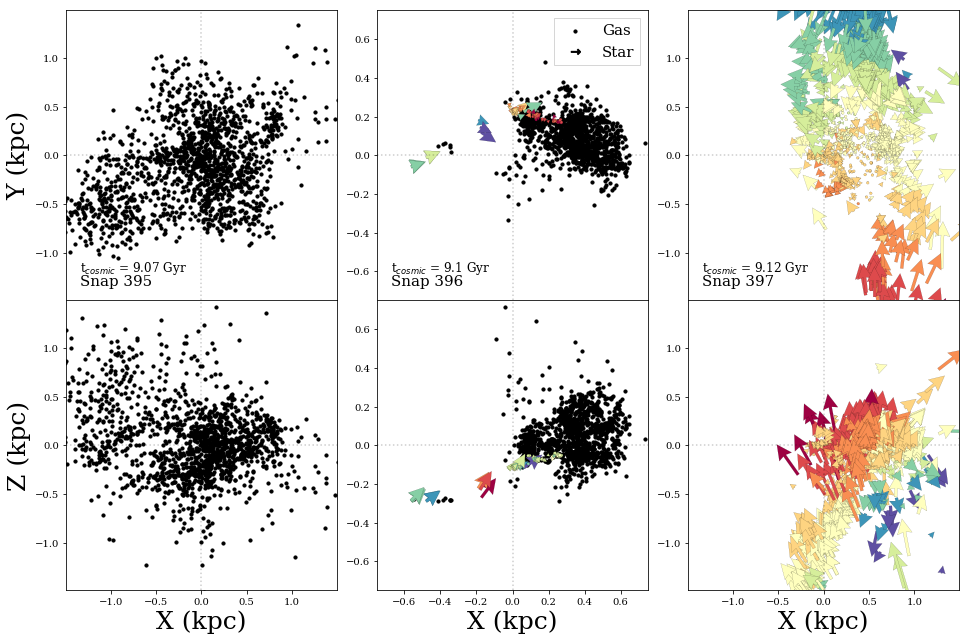

In [44]:
fig, ( (ax1, ax2, ax3), (ax4, ax5, ax6) ) = plt.subplots(nrows = 2, ncols = 3, sharex = False, sharey = False,
                                                                         figsize = (16,10.67))
axes = [ax1,ax2,ax3,ax4,ax5,ax6]
boxsizes = [1.49,0.75,1.49]
particle_size = ps = 10
bbr = spec_disc # COLORMAP HERE
alpha_l = 0.2
times = [9.07, 9.10, 9.12]

for i in range(0, 3):
    cgrad = ages[i][np.isin(idss[i],idsoi)]
    indg = [np.isin(idgs[i],idsoi)]
    indg0 = [np.isin(idgs[0],idsoi)]
    indst = [np.isin(idss[i],idsoi)]
    
    #plotting gas particles
    axes[i].scatter(xgs[i][indg], ygs[i][indg], s = ps, c = 'black', label = 'Gas')
    axes[i+3].scatter(xgs[i][indg], zgs[i][indg], s = ps, c = 'black')

  
    #plotting star particles 
    
    axes[i].quiver(xs[i][indst], ys[i][indst], velss[i][:,0][indst]-hvels[i][0][0], 
           velss[i][:,1][indst]-hvels[i][0][1], velss[i][:,2][indst]-hvels[i][0][2], 
                   pivot = 'tail', scale = 2.5, headwidth = 5, units = 'dots', cmap = bbr,
                  width = 3, edgecolor = 'black', linewidths = 0.1)
    
    axes[i+3].quiver(xs[i][indst], zs[i][indst], velss[i][:,0][indst]-hvels[i][0][0], 
            velss[i][:,2][indst]-hvels[i][0][2], velss[i][:,1][indst]-hvels[i][0][1],
                   pivot = 'tail', scale = 2.5, headwidth = 5, units = 'dots', cmap = bbr,
                  width = 3, edgecolor = 'black', linewidths = 0.1)
    
    #axes[i].scatter(xs[i][np.isin(idss[i],idsoi)], ys[i][np.isin(idss[i],idsoi)], s = ps, c = 'black', cmap = bbr,
    #                marker = "*")
    #
    #axes[i+3].scatter(xs[i][np.isin(idss[i],idsoi)], zs[i][np.isin(idss[i],idsoi)], s = ps, c = 'black', cmap = bbr,
    #                  marker = "*")
    
    #plot adjusments
    axes[i].text(-boxsizes[i]*.9,-boxsizes[i]*.9, "Snap " + str(relevant_snapshots[i]), size = 15)
    axes[i].text(-boxsizes[i]*.9,-boxsizes[i]*.8, r"t$_{cosmic}$ = " + str(times[i]) + " Gyr", size = 12)
    axes[i+3].set_xlim(-boxsizes[i],boxsizes[i])
    axes[i+3].set_ylim(-boxsizes[i],boxsizes[i])
    axes[i].set_xlim(-boxsizes[i],boxsizes[i])
    axes[i].set_ylim(-boxsizes[i],boxsizes[i])
    xticks = axes[i].xaxis.get_majorticklabels()
    yticks = axes[i].yaxis.get_majorticklabels()
    plt.setp(xticks, visible=False)
    
    
    
    axes[i].axvline(0, ls = ":", color = 'black', alpha = alpha_l)
    axes[i].axhline(0, ls = ":", color = 'black', alpha = alpha_l)
    axes[i+3].axvline(0, ls = ":", color = 'black', alpha = alpha_l)
    axes[i+3].axhline(0, ls = ":", color = 'black', alpha = alpha_l)
    
axes[0].set_ylabel("Y (kpc)", size = 25)
axes[3].set_ylabel("Z (kpc)", size = 25)

for i in range(3,6):
    axes[i].set_xlabel("X (kpc)", size = 25)

axes[1].scatter(-5,-5, marker = r"$\rightarrow$", s = 100, color = 'black', label = 'Star')
#axes[1].scatter(-5,-5, marker = "*", s = 40, label = "Star", color = 'black')
axes[1].legend(fontsize = 15, fancybox = False)
    
plt.subplots_adjust(wspace = 0.15, hspace = 0.)

plt.savefig("m11b_star_velocities.png", dpi = 150, bbox_inches = 'tight')
plt.show()


# PLOT 3 BELOW

In [45]:
# libraries
from scipy.stats import kde
nbins=300 
xs0 = []
ys0 = []
zs0 = []
ks0 = []
xis0 = []
yis0 = []


# create data
for i in range(0,1):
    xs0.append(xs[1][np.isin(idss[1],idsoi)]) # Why is this i + 3? See "ilist" above, only relevant for m11b analysis.
    ys0.append(zs[1][np.isin(idss[1],idsoi)]) # In principle, this shouldn't need to comb a list with any offset. 
    
    k0 = kde.gaussian_kde([xs0[i],ys0[i]])

    xi0, yi0 = np.mgrid[xs0[i].min():xs0[i].max():nbins*1j, ys0[i].min():ys0[i].max()+0.1:nbins*1j]
    xis0.append(xi0)
    yis0.append(yi0)
    zs0.append(k0(np.vstack([xi0.flatten(), yi0.flatten()])))

In [46]:
cgrads = []
indgs = []
indg0s = [] 
indsts = []

for i in range(0, 3):
    cgrads.append(ages[i][np.isin(idss[i],idsoi)])
    indgs.append([np.isin(idgs[i],idsoi)])
    indg0s.append([np.isin(idgs[0],idsoi)])
    indsts.append([np.isin(idss[i],idsoi)])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:131: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:133: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an err

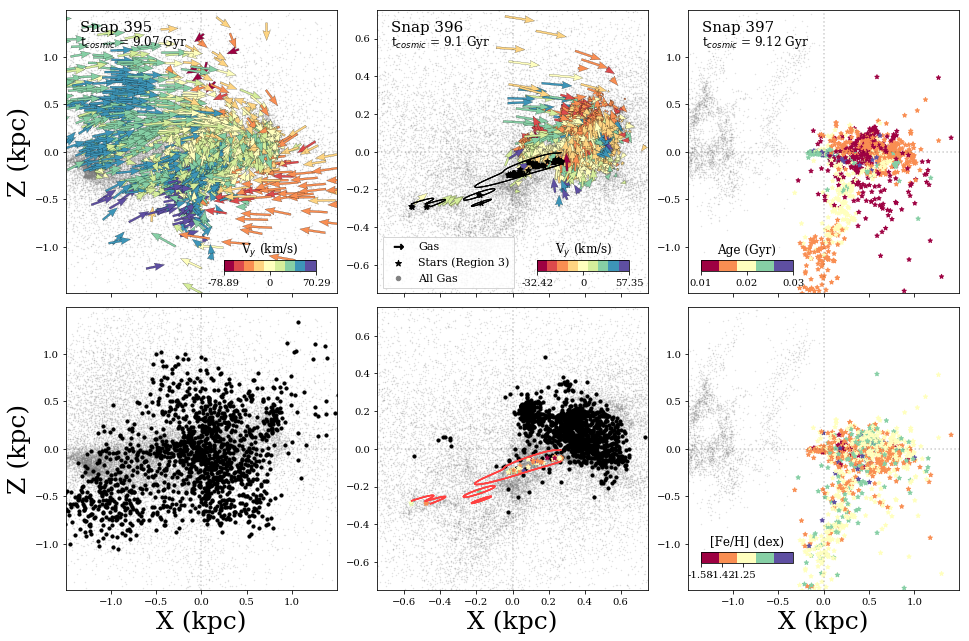

In [47]:
fig, ( (ax1, ax2, ax3), (ax4, ax5, ax6) ) = plt.subplots(nrows = 2, ncols = 3, sharex = False, sharey = False,
                                                                         figsize = (16,10.67))
axes = [ax1,ax2,ax3,ax4,ax5,ax6]
boxsizes = [1.49,0.75,1.49]
particle_size = ps = 20
bbr = spec_disc # COLORMAP HERE
alpha_l = 0.2
times = [9.07, 9.10, 9.12]
mthresh = -1.25 # [Fe/H] threshold for stars colored by fe/h

########################################################################################################################
vy0 = velgs[0][:,1][indgs[0]]-hvels[0][0][1]

counts1,xbins1,ybins1,image1 = axes[0].hist2d(velgs[0][:,0][indgs[0]]-hvels[0][0][0], 
                                          velgs[0][:,2][indgs[0]]-hvels[0][0][2], 
                                          bins = [100,100])

#"mean age" is a just a 
mean_1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(velgs[0][:,0][indgs[0]]-hvels[0][0][0], # x vel of gas
                                                                    velgs[0][:,2][indgs[0]]-hvels[0][0][2], # z vel
                                                                    velgs[0][:,1][indgs[0]]-hvels[0][0][1], # y vel
                                                                    'mean', bins= [100,100])
#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_1)
im1 = axes[0].imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = bbr, aspect='auto'
                 , vmin=np.min(velgs[0][:,1][indgs[0]]-hvels[0][0][1])
                 , vmax=np.max(velgs[0][:,1][indgs[0]]-hvels[0][0][1]))

axes[0].clear()

cbar_ax = fig.add_axes([ 0.262, 0.54, 0.08, 0.015]) #left, bottom, width, height
cb = fig.colorbar(im1, cax=cbar_ax, 
                  ticks = [np.min(velgs[0][:,1][indgs[0]]-hvels[0][0][1]),
                           (np.min(velgs[0][:,1][indgs[0]]-hvels[0][0][1])+np.max(velgs[0][:,1][indgs[0]]-hvels[0][0][1]))/2,
                           np.max(velgs[0][:,1][indgs[0]]-hvels[0][0][1])], 
                  orientation='horizontal')

cb.ax.xaxis.set_ticks_position("bottom")
cb.ax.set_xticklabels([round(np.min(velgs[0][:,1][indgs[0]]-hvels[0][0][1]),2),
                           0,
                           round(np.max(velgs[0][:,1][indgs[0]]-hvels[0][0][1]),2)],
                      fontweight = 8) # Used to make custom labels on the tick marks themselves
cb.ax.set_title(r"V$_{y}$ (km/s)")
#########################################################################################################################
vy0 = velgs[1][:,1][indgs[1]]-hvels[1][0][1]

counts1,xbins1,ybins1,image1 = axes[1].hist2d(velgs[1][:,0][indgs[1]]-hvels[1][0][0], 
                                          velgs[1][:,2][indgs[1]]-hvels[1][0][2], 
                                          bins = [100,100])

#"mean age" is a just a 
mean_1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(velgs[1][:,0][indgs[1]]-hvels[1][0][0], # x vel of gas
                                                                    velgs[1][:,2][indgs[1]]-hvels[1][0][2], # z vel
                                                                    velgs[1][:,1][indgs[1]]-hvels[1][0][1], # y vel
                                                                    'mean', bins= [100,100])
#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_1)
im1 = axes[1].imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = bbr, aspect='auto'
                 , vmin=np.min(velgs[1][:,1][indgs[1]]-hvels[1][0][1])
                 , vmax=np.max(velgs[1][:,1][indgs[1]]-hvels[1][0][1]))

axes[1].clear()

cbar_ax = fig.add_axes([ 0.262+.272, 0.54, 0.08, 0.015]) #left, bottom, width, height
cb = fig.colorbar(im1, cax=cbar_ax, 
                  ticks = [np.min(velgs[1][:,1][indgs[1]]-hvels[1][0][1]),
                           (np.min(velgs[1][:,1][indgs[1]]-hvels[1][0][1])+np.max(velgs[1][:,1][indgs[1]]-hvels[1][0][1]))/2,
                           np.max(velgs[1][:,1][indgs[1]]-hvels[1][0][1])], 
                  orientation='horizontal')

cb.ax.xaxis.set_ticks_position("bottom")
cb.ax.set_xticklabels([round(np.min(velgs[1][:,1][indgs[1]]-hvels[1][0][1]),2),
                           0,
                           round(np.max(velgs[1][:,1][indgs[1]]-hvels[1][0][1]),2)],
                      fontweight = 8) # Used to make custom labels on the tick marks themselves
cb.ax.set_title(r"V$_{y}$ (km/s)")
#########################################################################################################################
counts1,xbins1,ybins1,image1 = axes[2].hist2d(xs[2][np.isin(idss[2],idsoi)], 
                                          ys[2][np.isin(idss[2],idsoi)], 
                                          bins = [100,100])

#"mean age" is a just a 
mean_1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(xs[2][np.isin(idss[2],idsoi)], 
                                                                 ys[2][np.isin(idss[2],idsoi)],
                                                                 ages[2][np.isin(idss[2], idsoi)],'mean', bins= [100,100])
#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_1)
im1 = axes[2].imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = gnu, aspect='auto'
                 , vmin=np.min(ages[2][np.isin(idss[2], idsoi)])
                 , vmax=np.max(ages[2][np.isin(idss[2], idsoi)]))

axes[2].clear()

cbar_ax = fig.add_axes([ 0.262+.272+.272-.13, 0.54, 0.08, 0.015]) #left, bottom, width, height
cb = fig.colorbar(im1, cax=cbar_ax, 
                  ticks = [np.min(ages[2][np.isin(idss[2], idsoi)]),
                           (np.min(ages[2][np.isin(idss[2], idsoi)])+np.max(ages[2][np.isin(idss[2], idsoi)]))/2,
                           np.max(ages[2][np.isin(idss[2], idsoi)])], orientation='horizontal')

cb.ax.xaxis.set_ticks_position("bottom")
cb.ax.set_xticklabels([round(np.min(ages[2][np.isin(idss[2], idsoi)]),2),
                           round((np.min(ages[2][np.isin(idss[2], idsoi)])+np.max(ages[2][np.isin(idss[2], idsoi)]))/2, 2),
                           round(np.max(ages[2][np.isin(idss[2], idsoi)]),2)],
                      fontweight = 8) # Used to make custom labels on the tick marks themselves
cb.ax.set_title(r"Age (Gyr)")
#########################################################################################################################
counts1,xbins1,ybins1,image1 = axes[5].hist2d(xs[2][np.isin(idss[2],idsoi)], 
                                          ys[2][np.isin(idss[2],idsoi)], 
                                          bins = [100,100])

crazyind = [np.where(fehs[2][np.isin(idss[2],idsoi)] < mthresh)]

#"mean age" is a just a 
mean_1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(xs[2][np.isin(idss[2],idsoi)], 
                                                                 ys[2][np.isin(idss[2],idsoi)],
                                                                 fehs[2][np.isin(idss[2], idsoi)],'mean', bins= [100,100])
#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_1)
im1 = axes[5].imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = gnu, aspect='auto'
                 , vmin=np.min(fehs[2][np.isin(idss[2], idsoi)])
                 , vmax=np.max(fehs[2][np.isin(idss[2], idsoi)]))

axes[5].clear()

cbar_ax = fig.add_axes([ 0.262+.272+.272-.13, 0.54-.38, 0.08, 0.015]) #left, bottom, width, height
cb = fig.colorbar(im1, cax=cbar_ax, 
                  ticks = [np.min(fehs[2][np.isin(idss[2], idsoi)][crazyind]),
                           (np.min(fehs[2][np.isin(idss[2], idsoi)][crazyind])+
                            np.max(fehs[2][np.isin(idss[2], idsoi)][crazyind]))/2,
                           np.max(fehs[2][np.isin(idss[2], idsoi)][crazyind])], orientation='horizontal')

cb.ax.xaxis.set_ticks_position("bottom")
cb.ax.set_xticklabels([round(np.min(fehs[2][np.isin(idss[2], idsoi)][crazyind]),2),
                           round((np.min(fehs[2][np.isin(idss[2], idsoi)][crazyind])+
                                  np.max(fehs[2][np.isin(idss[2], idsoi)][crazyind]))/2, 2),
                           round(np.max(fehs[2][np.isin(idss[2], idsoi)][crazyind]),2)],
                      fontweight = 8) # Used to make custom labels on the tick marks themselves
cb.ax.set_title(r"[Fe/H] (dex)")
#########################################################################################################################
#########################################################################################################################


for i in range(0, 3):
    
    #plotting gas particles
    axes[i+3].scatter(xgs[i][np.where(rgs[i] < 2)], zgs[i][np.where(rgs[i] < 2)], s = ps/100, c = 'gray', alpha = 0.25)
    # DO NOT CHANGE BELOW - YIS corresponds to arbitary y coordinate, NOT spatial coordinates for simulation.
    axes[1].contour(xis0[0], yis0[0], zs0[0].reshape(xis[0].shape), levels = [2], colors = 'black', linewidths = 1) 
    axes[4].contour(xis0[0], yis0[0], zs0[0].reshape(xis[0].shape), levels = [2], colors = '#ff4040') 
    # DO NOT CHANGE ABOVE 
    axes[i].scatter(xgs[i][np.where(rgs[i] < 2)], zgs[i][np.where(rgs[i] < 2)], s = ps/100, c = 'gray', alpha = 0.25)
    axes[i+3].scatter(xgs[i][indgs[i]], ygs[i][indgs[i]], s = ps/2, c = 'black', label = 'Gas (Region 3)')
    #axes[i+3].scatter(xgs[i][indg], zgs[i][indg], s = ps/2, c = 'black')
    
    #axes[i].quiver(xgs[i][indg], ygs[i][indg], velgs[i][:,0][indg]-hvels[i][0][0], 
    #       velgs[i][:,1][indg]-hvels[i][0][1], velgs[i][:,2][indg]-hvels[i][0][2], 
    #               pivot = 'tail', scale = 2.5, headwidth = 5, units = 'dots', cmap = bbr,
    #              width = 3, edgecolor = 'black', linewidths = 0.1)
    
    axes[i].quiver(xgs[i][indgs[i]], zgs[i][indgs[i]], velgs[i][:,0][indgs[i]]-hvels[i][0][0], 
           velgs[i][:,2][indgs[i]]-hvels[i][0][2], velgs[i][:,1][indgs[i]]-hvels[i][0][1], 
                   pivot = 'tail', scale = 2.5, headwidth = 3.75, units = 'dots', cmap = bbr,
                  width = 2, edgecolor = 'black', linewidths = 0.18) 

  
    #plotting star particles 
    
    #axes[i].quiver(xs[i][indst], ys[i][indst], velss[i][:,0][indst]-hvels[i][0][0], 
    #       velss[i][:,1][indst]-hvels[i][0][1], velss[i][:,2][indst]-hvels[i][0][2], 
    #               pivot = 'tail', scale = 4, headwidth = 5, units = 'dots', cmap = bbr,
    #              width = 1, edgecolor = 'black', linewidths = 0.1)
    #
    #axes[i+3].quiver(xs[i][indst], zs[i][indst], velss[i][:,0][indst]-hvels[i][0][0], 
    #        velss[i][:,2][indst]-hvels[i][0][2], velss[i][:,1][indst]-hvels[i][0][1],
    #               pivot = 'tail', scale = 4, headwidth = 5, units = 'dots', cmap = bbr,
    #              width = 1, edgecolor = 'black', linewidths = 0.1)
    if(i > 0):
        if(i == 1):
            axes[i].scatter(xs[i][np.isin(idss[i],idsoi)], zs[i][np.isin(idss[i],idsoi)], s = ps+10, c = 'black',
                            marker = "*")
        if(i == 2):
            axes[i].scatter(xs[i][np.isin(idss[i],idsoi)], zs[i][np.isin(idss[i],idsoi)], s = ps, c = cgrads[i], cmap = gnu,
                            marker = "*")
        
        crazyind = [np.where(fehs[i][np.isin(idss[i],idsoi)] < mthresh)]
        axes[i+3].scatter(xs[i][np.isin(idss[i],idsoi)][crazyind], zs[i][np.isin(idss[i],idsoi)][crazyind], s = ps, 
                          c = fehs[i][np.isin(idss[i],idsoi)][crazyind], cmap = gnu,
                          marker = "*")
    
    #plot adjusments
    axes[i].text(-boxsizes[i]*.9,boxsizes[i]*.85, "Snap " + str(relevant_snapshots[i]), size = 15)
    axes[i].text(-boxsizes[i]*.9,boxsizes[i]*.75, r"t$_{cosmic}$ = " + str(times[i]) + " Gyr", size = 12)
    axes[i].set_xlim(-boxsizes[i],boxsizes[i])
    axes[i].set_ylim(-boxsizes[i],boxsizes[i])
    axes[i+3].set_xlim(-boxsizes[i],boxsizes[i])
    axes[i+3].set_ylim(-boxsizes[i],boxsizes[i])
    xticks = axes[i].xaxis.get_majorticklabels()
    yticks = axes[i].yaxis.get_majorticklabels()
    plt.setp(xticks, visible=False)
    
    
    
    axes[i+3].axvline(0, ls = ":", color = 'black', alpha = alpha_l)
    axes[i+3].axhline(0, ls = ":", color = 'black', alpha = alpha_l)
    axes[i].axvline(0, ls = ":", color = 'black', alpha = alpha_l)
    axes[i].axhline(0, ls = ":", color = 'black', alpha = alpha_l)
    
axes[0].set_ylabel("Z (kpc)", size = 25)
axes[3].set_ylabel("Z (kpc)", size = 25)

for i in range(3,6):
    axes[i].set_xlabel("X (kpc)", size = 25)

axes[1].scatter(-5,-5, marker = r"$\rightarrow$", s = 100, color = 'black', label = 'Gas')
axes[1].scatter(-5,-5, marker = "*", s = 40, label = "Stars (Region 3)", color = 'black')
axes[1].scatter(-5,-5, s = ps, label = "All Gas", color = 'gray')
axes[1].legend(fontsize = 11, loc = 3, fancybox = False)
    
plt.subplots_adjust(wspace = 0.15, hspace = 0.05)
plt.savefig("m11b_" + str(d1) + ".png", dpi = 100, bbox_inches = 'tight')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:131: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:133: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an err

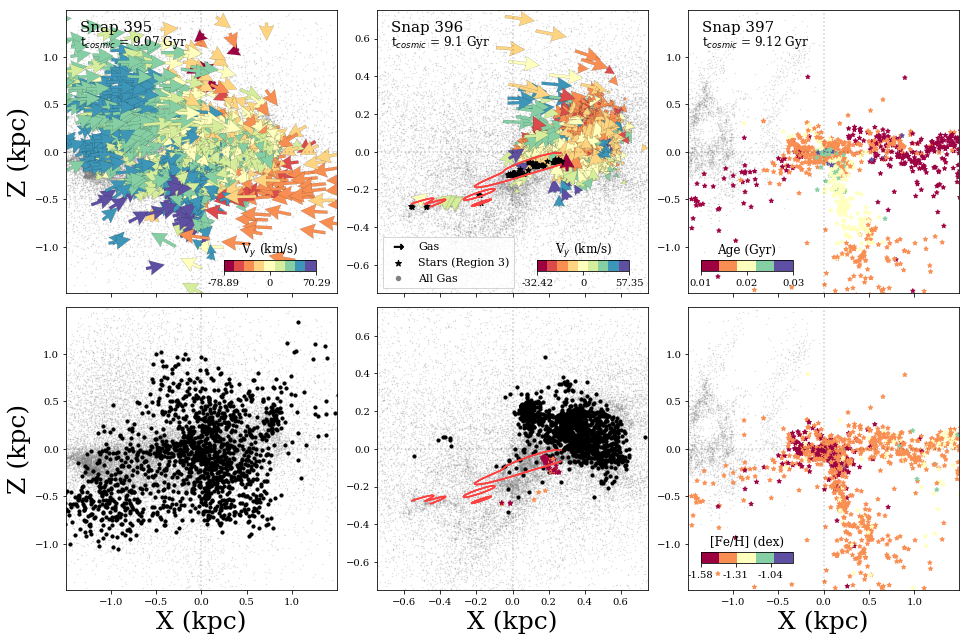

In [48]:
fig, ( (ax1, ax2, ax3), (ax4, ax5, ax6) ) = plt.subplots(nrows = 2, ncols = 3, sharex = False, sharey = False,
                                                                         figsize = (16,10.67))
axes = [ax1,ax2,ax3,ax4,ax5,ax6]
boxsizes = [1.49,0.75,1.49]
particle_size = ps = 20
bbr = spec_disc # COLORMAP HERE
alpha_l = 0.2
times = [9.07, 9.10, 9.12]
mthresh = -1.0 # [Fe/H] threshold for stars colored by fe/h

########################################################################################################################
vy0 = velgs[0][:,1][indgs[0]]-hvels[0][0][1]

counts1,xbins1,ybins1,image1 = axes[0].hist2d(velgs[0][:,0][indgs[0]]-hvels[0][0][0], 
                                          velgs[0][:,2][indgs[0]]-hvels[0][0][2], 
                                          bins = [100,100])

#"mean age" is a just a 
mean_1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(velgs[0][:,0][indgs[0]]-hvels[0][0][0], # x vel of gas
                                                                    velgs[0][:,2][indgs[0]]-hvels[0][0][2], # z vel
                                                                    velgs[0][:,1][indgs[0]]-hvels[0][0][1], # y vel
                                                                    'mean', bins= [100,100])
#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_1)
im1 = axes[0].imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = bbr, aspect='auto'
                 , vmin=np.min(velgs[0][:,1][indgs[0]]-hvels[0][0][1])
                 , vmax=np.max(velgs[0][:,1][indgs[0]]-hvels[0][0][1]))

axes[0].clear()

cbar_ax = fig.add_axes([ 0.262, 0.54, 0.08, 0.015]) #left, bottom, width, height
cb = fig.colorbar(im1, cax=cbar_ax, 
                  ticks = [np.min(velgs[0][:,1][indgs[0]]-hvels[0][0][1]),
                           (np.min(velgs[0][:,1][indgs[0]]-hvels[0][0][1])+np.max(velgs[0][:,1][indgs[0]]-hvels[0][0][1]))/2,
                           np.max(velgs[0][:,1][indgs[0]]-hvels[0][0][1])], 
                  orientation='horizontal')

cb.ax.xaxis.set_ticks_position("bottom")
cb.ax.set_xticklabels([round(np.min(velgs[0][:,1][indgs[0]]-hvels[0][0][1]),2),
                           0,
                           round(np.max(velgs[0][:,1][indgs[0]]-hvels[0][0][1]),2)],
                      fontweight = 8) # Used to make custom labels on the tick marks themselves
cb.ax.set_title(r"V$_{y}$ (km/s)")
#########################################################################################################################
vy0 = velgs[1][:,1][indgs[1]]-hvels[1][0][1]

counts1,xbins1,ybins1,image1 = axes[1].hist2d(velgs[1][:,0][indgs[1]]-hvels[1][0][0], 
                                          velgs[1][:,2][indgs[1]]-hvels[1][0][2], 
                                          bins = [100,100])

#"mean age" is a just a 
mean_1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(velgs[1][:,0][indgs[1]]-hvels[1][0][0], # x vel of gas
                                                                    velgs[1][:,2][indgs[1]]-hvels[1][0][2], # z vel
                                                                    velgs[1][:,1][indgs[1]]-hvels[1][0][1], # y vel
                                                                    'mean', bins= [100,100])
#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_1)
im1 = axes[1].imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = bbr, aspect='auto'
                 , vmin=np.min(velgs[1][:,1][indgs[1]]-hvels[1][0][1])
                 , vmax=np.max(velgs[1][:,1][indgs[1]]-hvels[1][0][1]))

axes[1].clear()

cbar_ax = fig.add_axes([ 0.262+.272, 0.54, 0.08, 0.015]) #left, bottom, width, height
cb = fig.colorbar(im1, cax=cbar_ax, 
                  ticks = [np.min(velgs[1][:,1][indgs[1]]-hvels[1][0][1]),
                           (np.min(velgs[1][:,1][indgs[1]]-hvels[1][0][1])+np.max(velgs[1][:,1][indgs[1]]-hvels[1][0][1]))/2,
                           np.max(velgs[1][:,1][indgs[1]]-hvels[1][0][1])], 
                  orientation='horizontal')

cb.ax.xaxis.set_ticks_position("bottom")
cb.ax.set_xticklabels([round(np.min(velgs[1][:,1][indgs[1]]-hvels[1][0][1]),2),
                           0,
                           round(np.max(velgs[1][:,1][indgs[1]]-hvels[1][0][1]),2)],
                      fontweight = 8) # Used to make custom labels on the tick marks themselves
cb.ax.set_title(r"V$_{y}$ (km/s)")
#########################################################################################################################
counts1,xbins1,ybins1,image1 = axes[2].hist2d(xs[2][np.isin(idss[2],idsoi)], 
                                          ys[2][np.isin(idss[2],idsoi)], 
                                          bins = [100,100])

#"mean age" is a just a 
mean_1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(xs[2][np.isin(idss[2],idsoi)], 
                                                                 ys[2][np.isin(idss[2],idsoi)],
                                                                 ages[2][np.isin(idss[2], idsoi)],'mean', bins= [100,100])
#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_1)
im1 = axes[2].imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = gnu, aspect='auto'
                 , vmin=np.min(ages[2][np.isin(idss[2], idsoi)])
                 , vmax=np.max(ages[2][np.isin(idss[2], idsoi)]))

axes[2].clear()

cbar_ax = fig.add_axes([ 0.262+.272+.272-.13, 0.54, 0.08, 0.015]) #left, bottom, width, height
cb = fig.colorbar(im1, cax=cbar_ax, 
                  ticks = [np.min(ages[2][np.isin(idss[2], idsoi)]),
                           (np.min(ages[2][np.isin(idss[2], idsoi)])+np.max(ages[2][np.isin(idss[2], idsoi)]))/2,
                           np.max(ages[2][np.isin(idss[2], idsoi)])], orientation='horizontal')

cb.ax.xaxis.set_ticks_position("bottom")
cb.ax.set_xticklabels([round(np.min(ages[2][np.isin(idss[2], idsoi)]),2),
                           round((np.min(ages[2][np.isin(idss[2], idsoi)])+np.max(ages[2][np.isin(idss[2], idsoi)]))/2, 2),
                           round(np.max(ages[2][np.isin(idss[2], idsoi)]),2)],
                      fontweight = 8) # Used to make custom labels on the tick marks themselves
cb.ax.set_title(r"Age (Gyr)")
#########################################################################################################################
counts1,xbins1,ybins1,image1 = axes[5].hist2d(xs[2][np.isin(idss[2],idsoi)], 
                                          ys[2][np.isin(idss[2],idsoi)], 
                                          bins = [100,100])

crazyind = [np.where(fehs[2][np.isin(idss[2],idsoi)] < mthresh)]

#"mean age" is a just a 
mean_1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(xs[2][np.isin(idss[2],idsoi)], 
                                                                 ys[2][np.isin(idss[2],idsoi)],
                                                                 fehs[2][np.isin(idss[2], idsoi)],'mean', bins= [100,100])
#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_1)
im1 = axes[5].imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = gnu, aspect='auto'
                 , vmin=np.min(fehs[2][np.isin(idss[2], idsoi)])
                 , vmax=np.max(fehs[2][np.isin(idss[2], idsoi)]))

axes[5].clear()

cbar_ax = fig.add_axes([ 0.262+.272+.272-.13, 0.54-.38, 0.08, 0.015]) #left, bottom, width, height
cb = fig.colorbar(im1, cax=cbar_ax, 
                  ticks = [np.min(fehs[2][np.isin(idss[2], idsoi)][crazyind]),
                           (np.min(fehs[2][np.isin(idss[2], idsoi)][crazyind])+
                            np.max(fehs[2][np.isin(idss[2], idsoi)][crazyind]))/2,
                           np.max(fehs[2][np.isin(idss[2], idsoi)][crazyind])], orientation='horizontal')

cb.ax.xaxis.set_ticks_position("bottom")
cb.ax.set_xticklabels([round(np.min(fehs[2][np.isin(idss[2], idsoi)][crazyind]),2),
                           round((np.min(fehs[2][np.isin(idss[2], idsoi)][crazyind])+
                                  np.max(fehs[2][np.isin(idss[2], idsoi)][crazyind]))/2, 2),
                           round(np.max(fehs[2][np.isin(idss[2], idsoi)][crazyind]),2)],
                      fontweight = 8) # Used to make custom labels on the tick marks themselves
cb.ax.set_title(r"[Fe/H] (dex)")
#########################################################################################################################
#########################################################################################################################


for i in range(0, 3):
    
    #plotting gas particles
    axes[i+3].scatter(xgs[i][np.where(rgs[i] < 2)], zgs[i][np.where(rgs[i] < 2)], s = ps/100, c = 'gray', alpha = 0.25)
    # DO NOT CHANGE BELOW - YIS corresponds to arbitary y coordinate, NOT spatial coordinates for simulation.
    axes[1].contour(xis0[0], yis0[0], zs0[0].reshape(xis[0].shape), levels = [2], colors = '#ff4040') 
    axes[4].contour(xis0[0], yis0[0], zs0[0].reshape(xis[0].shape), levels = [2], colors = '#ff4040') 
    # DO NOT CHANGE ABOVE 
    axes[i].scatter(xgs[i][np.where(rgs[i] < 2)], zgs[i][np.where(rgs[i] < 2)], s = ps/100, c = 'gray', alpha = 0.25)
    axes[i+3].scatter(xgs[i][indgs[i]], ygs[i][indgs[i]], s = ps/2, c = 'black', label = 'Gas (Region 3)')
    #axes[i+3].scatter(xgs[i][indg], zgs[i][indg], s = ps/2, c = 'black')
    
    #axes[i].quiver(xgs[i][indg], ygs[i][indg], velgs[i][:,0][indg]-hvels[i][0][0], 
    #       velgs[i][:,1][indg]-hvels[i][0][1], velgs[i][:,2][indg]-hvels[i][0][2], 
    #               pivot = 'tail', scale = 2.5, headwidth = 5, units = 'dots', cmap = bbr,
    #              width = 3, edgecolor = 'black', linewidths = 0.1)
    
    axes[i].quiver(xgs[i][indgs[i]], zgs[i][indgs[i]], velgs[i][:,0][indgs[i]]-hvels[i][0][0], 
           velgs[i][:,2][indgs[i]]-hvels[i][0][2], velgs[i][:,1][indgs[i]]-hvels[i][0][1], 
                   pivot = 'tail', scale = 2.5, headwidth = 5, units = 'dots', cmap = bbr,
                  width = 3, edgecolor = 'black', linewidths = 0.1) 

  
    #plotting star particles 
    
    #axes[i].quiver(xs[i][indst], ys[i][indst], velss[i][:,0][indst]-hvels[i][0][0], 
    #       velss[i][:,1][indst]-hvels[i][0][1], velss[i][:,2][indst]-hvels[i][0][2], 
    #               pivot = 'tail', scale = 4, headwidth = 5, units = 'dots', cmap = bbr,
    #              width = 1, edgecolor = 'black', linewidths = 0.1)
    #
    #axes[i+3].quiver(xs[i][indst], zs[i][indst], velss[i][:,0][indst]-hvels[i][0][0], 
    #        velss[i][:,2][indst]-hvels[i][0][2], velss[i][:,1][indst]-hvels[i][0][1],
    #               pivot = 'tail', scale = 4, headwidth = 5, units = 'dots', cmap = bbr,
    #              width = 1, edgecolor = 'black', linewidths = 0.1)
    if(i > 0):
        if(i == 1):
            axes[i].scatter(xs[i][np.isin(idss[i],idsoi)], zs[i][np.isin(idss[i],idsoi)], s = ps+10, c = 'black',
                            marker = "*")
        if(i == 2):
            axes[i].scatter(ys[i][np.isin(idss[i],idsoi)], zs[i][np.isin(idss[i],idsoi)], s = ps, c = cgrads[i], cmap = gnu,
                            marker = "*")
        
        crazyind = [np.where(fehs[i][np.isin(idss[i],idsoi)] < mthresh)]
        axes[i+3].scatter(ys[i][np.isin(idss[i],idsoi)][crazyind], zs[i][np.isin(idss[i],idsoi)][crazyind], s = ps, 
                          c = fehs[i][np.isin(idss[i],idsoi)][crazyind], cmap = gnu,
                          marker = "*")
    
    #plot adjusments
    axes[i].text(-boxsizes[i]*.9,boxsizes[i]*.85, "Snap " + str(relevant_snapshots[i]), size = 15)
    axes[i].text(-boxsizes[i]*.9,boxsizes[i]*.75, r"t$_{cosmic}$ = " + str(times[i]) + " Gyr", size = 12)
    axes[i].set_xlim(-boxsizes[i],boxsizes[i])
    axes[i].set_ylim(-boxsizes[i],boxsizes[i])
    axes[i+3].set_xlim(-boxsizes[i],boxsizes[i])
    axes[i+3].set_ylim(-boxsizes[i],boxsizes[i])
    xticks = axes[i].xaxis.get_majorticklabels()
    yticks = axes[i].yaxis.get_majorticklabels()
    plt.setp(xticks, visible=False)
    
    
    
    axes[i+3].axvline(0, ls = ":", color = 'black', alpha = alpha_l)
    axes[i+3].axhline(0, ls = ":", color = 'black', alpha = alpha_l)
    axes[i].axvline(0, ls = ":", color = 'black', alpha = alpha_l)
    axes[i].axhline(0, ls = ":", color = 'black', alpha = alpha_l)
    
axes[0].set_ylabel("Z (kpc)", size = 25)
axes[3].set_ylabel("Z (kpc)", size = 25)

for i in range(3,6):
    axes[i].set_xlabel("X (kpc)", size = 25)

axes[1].scatter(-5,-5, marker = r"$\rightarrow$", s = 100, color = 'black', label = 'Gas')
axes[1].scatter(-5,-5, marker = "*", s = 40, label = "Stars (Region 3)", color = 'black')
axes[1].scatter(-5,-5, s = ps, label = "All Gas", color = 'gray')
axes[1].legend(fontsize = 11, loc = 3, fancybox = False)
    
plt.subplots_adjust(wspace = 0.15, hspace = 0.05)
plt.savefig("m11b_yz_may21.png", dpi = 100, bbox_inches = 'tight')

In [49]:
for i in range(0, 3):
    
    #plotting gas particles
    axes[i+3].scatter(xgs[i][np.where(rgs[i] < 2)], ygs[i][np.where(rgs[i] < 2)], s = ps/100, c = 'gray', alpha = 0.25)
    axes[1].contour(xis0[0], yis0[0], zs0[0].reshape(xis[0].shape), levels = [3,6,9], cmap = "Reds")
    axes[i].scatter(xgs[i][np.where(rgs[i] < 2)], zgs[i][np.where(rgs[i] < 2)], s = ps/100, c = 'gray', alpha = 0.25)
    axes[i+3].scatter(xgs[i][indg], ygs[i][indg], s = ps/2, c = 'black', label = 'Gas (Region 3)')
    #axes[i+3].scatter(xgs[i][indg], zgs[i][indg], s = ps/2, c = 'black')
    
    #axes[i].quiver(xgs[i][indg], ygs[i][indg], velgs[i][:,0][indg]-hvels[i][0][0], 
    #       velgs[i][:,1][indg]-hvels[i][0][1], velgs[i][:,2][indg]-hvels[i][0][2], 
    #               pivot = 'tail', scale = 2.5, headwidth = 5, units = 'dots', cmap = bbr,
    #              width = 3, edgecolor = 'black', linewidths = 0.1)
    
    axes[i].quiver(xgs[i][indg], zgs[i][indg], velgs[i][:,0][indg]-hvels[i][0][0], 
           velgs[i][:,2][indg]-hvels[i][0][2], velgs[i][:,1][indg]-hvels[i][0][1], 
                   pivot = 'tail', scale = 2.5, headwidth = 5, units = 'dots', cmap = bbr,
                  width = 3, edgecolor = 'black', linewidths = 0.1) 

  
    #plotting star particles 
    
    #axes[i].quiver(xs[i][indst], ys[i][indst], velss[i][:,0][indst]-hvels[i][0][0], 
    #       velss[i][:,1][indst]-hvels[i][0][1], velss[i][:,2][indst]-hvels[i][0][2], 
    #               pivot = 'tail', scale = 4, headwidth = 5, units = 'dots', cmap = bbr,
    #              width = 1, edgecolor = 'black', linewidths = 0.1)
    #
    #axes[i+3].quiver(xs[i][indst], zs[i][indst], velss[i][:,0][indst]-hvels[i][0][0], 
    #        velss[i][:,2][indst]-hvels[i][0][2], velss[i][:,1][indst]-hvels[i][0][1],
    #               pivot = 'tail', scale = 4, headwidth = 5, units = 'dots', cmap = bbr,
    #              width = 1, edgecolor = 'black', linewidths = 0.1)
    
    axes[i].scatter(xs[i][np.isin(idss[i],idsoi)], ys[i][np.isin(idss[i],idsoi)], s = ps, c = cgrad, cmap = bbr,
                    marker = "*")
    
    axes[i+3].scatter(xs[i][np.isin(idss[i],idsoi)], zs[i][np.isin(idss[i],idsoi)], s = ps, c = cgrad, cmap = bbr,
                      marker = "*")
    
    #plot adjusments
    axes[i].text(-boxsizes[i]*.9,boxsizes[i]*.85, "Snap " + str(relevant_snapshots[i]), size = 15)
    axes[i].text(-boxsizes[i]*.9,boxsizes[i]*.75, r"t$_{cosmic}$ = " + str(times[i]) + " Gyr", size = 12)
    axes[i].set_xlim(-boxsizes[i],boxsizes[i])
    axes[i].set_ylim(-boxsizes[i],boxsizes[i])
    axes[i+3].set_xlim(-boxsizes[i],boxsizes[i])
    axes[i+3].set_ylim(-boxsizes[i],boxsizes[i])
    xticks = axes[i].xaxis.get_majorticklabels()
    yticks = axes[i].yaxis.get_majorticklabels()
    plt.setp(xticks, visible=False)
    
    
    
    axes[i+3].axvline(0, ls = ":", color = 'black', alpha = alpha_l)
    axes[i+3].axhline(0, ls = ":", color = 'black', alpha = alpha_l)
    axes[i].axvline(0, ls = ":", color = 'black', alpha = alpha_l)
    axes[i].axhline(0, ls = ":", color = 'black', alpha = alpha_l)
    
axes[0].set_ylabel("Z (kpc)", size = 25)
axes[3].set_ylabel("Z (kpc)", size = 25)

for i in range(3,6):
    axes[i].set_xlabel("X (kpc)", size = 25)

#axes[1].scatter(-5,-5, marker = r"$\rightarrow$", s = 100, color = 'black', label = 'Star')
axes[1].scatter(-5,-5, marker = "*", s = 40, label = "Stars (Region 3)", color = 'black')
axes[1].scatter(-5,-5, s = ps, label = "All Gas", color = 'gray')
axes[1].legend(fontsize = 12, loc = 3, fancybox = False)
    
plt.subplots_adjust(wspace = 0.15, hspace = 0.05)
#plt.savefig("m11b_star_age_new.png", dpi = 100, bbox_inches = 'tight')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


IndexError: boolean index did not match indexed array along dimension 0; dimension is 22341620 but corresponding boolean dimension is 22339952

In [ ]:
# libraries
from scipy.stats import kde
nbins=300 
xs0 = []
ys0 = []
zs0 = []
ks0 = []
xis0 = []
yis0 = []


# create data
for i in range(0,1):
    xs0.append(xs[1][np.isin(idss[1],idsoi)]) # Why is this i + 3? See "ilist" above, only relevant for m11b analysis.
    ys0.append(ys[1][np.isin(idss[1],idsoi)]) # In principle, this shouldn't need to comb a list with any offset. 
    
    k0 = kde.gaussian_kde([xs0[i],ys0[i]])

    xi0, yi0 = np.mgrid[xs0[i].min():xs0[i].max():nbins*1j, ys0[i].min():ys0[i].max()+0.1:nbins*1j]
    xis0.append(xi0)
    yis0.append(yi0)
    zs0.append(k0(np.vstack([xi0.flatten(), yi0.flatten()])))

In [ ]:
fig, ( (ax1, ax2, ax3), (ax4, ax5, ax6) ) = plt.subplots(nrows = 2, ncols = 3, sharex = False, sharey = False,
                                                                         figsize = (16,10.67))
axes = [ax1,ax2,ax3,ax4,ax5,ax6]
boxsizes = [1.49,0.75,1.49]
particle_size = ps = 20
bbr = spec_disc # COLORMAP HERE
alpha_l = 0.2
times = [9.07, 9.10, 9.12]

########################################################################################################################
cgrad = ages[2][np.isin(idss[2],idsoi)]
indst = [np.isin(idss[2],idsoi)]

#mean age for bins of stars in mgfe vs feh space
mean_age1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(xs[2][indst], ys[2][indst], 
                                                                    fehs[2][indst], 'mean', bins= [100,100])


#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_age1)
im1 = ax6.imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = bbr, aspect='auto'
                 , vmin=np.min(fehs[2][indst])
                 , vmax=np.max(fehs[2][indst]))

divider = make_axes_locatable(ax3)
cax = divider.append_axes('top', size='5%', pad=0.4)

ax6.clear()
ticks1 = [np.min(fehs[2][indst]),(np.max(fehs[2][indst])+np.min(fehs[2][indst]))/2,np.max(fehs[2][indst])]
cb = fig.colorbar(im1, cax=cax, 
                  ticks = ticks1, 
                  orientation='horizontal')

cb.ax.xaxis.set_ticks_position("bottom")
cb.ax.set_xticklabels([str(round(ticks1[0],2)), str(round(ticks1[1],2)), str(round(ticks1[2],2))],
                      fontweight = 10) # Used to make custom labels on the tick marks themselves
cb.ax.set_title("[Fe/H] (dex)")
#########################################################################################################################


for i in range(0, 3):
    cgrad = fehs[i][np.isin(idss[i],idsoi)]
    indg = [np.isin(idgs[i],idsoi)]
    indg0 = [np.isin(idgs[0],idsoi)]
    indst = [np.isin(idss[i],idsoi)]
    
    #plotting gas particles
    axes[i].scatter(xgs[i][indg], ygs[i][indg], s = ps/10, c = 'black', label = 'Gas')
    axes[i+3].scatter(xgs[i][indg], zgs[i][indg], s = ps/10, c = 'black')

  
    #plotting star particles 
    
    #axes[i].quiver(xs[i][indst], ys[i][indst], velss[i][:,0][indst]-hvels[i][0][0], 
    #       velss[i][:,1][indst]-hvels[i][0][1], velss[i][:,2][indst]-hvels[i][0][2], 
    #               pivot = 'tail', scale = 4, headwidth = 5, units = 'dots', cmap = bbr,
    #              width = 1, edgecolor = 'black', linewidths = 0.1)
    #
    #axes[i+3].quiver(xs[i][indst], zs[i][indst], velss[i][:,0][indst]-hvels[i][0][0], 
    #        velss[i][:,2][indst]-hvels[i][0][2], velss[i][:,1][indst]-hvels[i][0][1],
    #               pivot = 'tail', scale = 4, headwidth = 5, units = 'dots', cmap = bbr,
    #              width = 1, edgecolor = 'black', linewidths = 0.1)
    
    axes[i].scatter(xs[i][np.isin(idss[i],idsoi)], ys[i][np.isin(idss[i],idsoi)], s = ps, c = cgrad, cmap = bbr,
                    marker = "*")
    
    axes[i+3].scatter(xs[i][np.isin(idss[i],idsoi)], zs[i][np.isin(idss[i],idsoi)], s = ps, c = cgrad, cmap = bbr,
                      marker = "*")
    
    #plot adjusments
    axes[i].text(-boxsizes[i]*.9,-boxsizes[i]*.9, "Snap " + str(relevant_snapshots[i]), size = 15)
    axes[i].text(-boxsizes[i]*.9,-boxsizes[i]*.8, r"t$_{cosmic}$ = " + str(times[i]) + " Gyr", size = 12)
    axes[i+3].set_xlim(-boxsizes[i],boxsizes[i])
    axes[i+3].set_ylim(-boxsizes[i],boxsizes[i])
    axes[i].set_xlim(-boxsizes[i],boxsizes[i])
    axes[i].set_ylim(-boxsizes[i],boxsizes[i])
    xticks = axes[i].xaxis.get_majorticklabels()
    yticks = axes[i].yaxis.get_majorticklabels()
    plt.setp(xticks, visible=False)
    
    
    
    axes[i].axvline(0, ls = ":", color = 'black', alpha = alpha_l)
    axes[i].axhline(0, ls = ":", color = 'black', alpha = alpha_l)
    axes[i+3].axvline(0, ls = ":", color = 'black', alpha = alpha_l)
    axes[i+3].axhline(0, ls = ":", color = 'black', alpha = alpha_l)
    
axes[0].set_ylabel("Y (kpc)", size = 25)
axes[3].set_ylabel("Z (kpc)", size = 25)

for i in range(3,6):
    axes[i].set_xlabel("X (kpc)", size = 25)

#axes[1].scatter(-5,-5, marker = r"$\rightarrow$", s = 100, color = 'black', label = 'Star')
axes[1].scatter(-5,-5, marker = "*", s = 40, label = "Star", color = 'black')
axes[1].legend(fontsize = 15, fancybox = False)
    
plt.subplots_adjust(wspace = 0.15, hspace = 0.)
plt.savefig("m11b_star_feh.png", dpi = 72, bbox_inches = 'tight')

In [ ]:
plt.figure(figsize = (15,15))
print(len(vel[:,1]))
print(len(xg[idloi]))
print(len(vel[:,0][np.isin(ids,idsoi)]))

M = np.hypot(vel[:,0][np.isin(ids,idsoi)], vel[:,1][np.isin(ids,idsoi)])

plt.scatter(xg[idloi], yg[idloi], c= 'red', s = 5)
plt.scatter(x[np.isin(ids,idsoi)], y[np.isin(ids,idsoi)], c = mgfe[np.isin(ids,idsoi)], s = 5)

print(np.max(age[np.isin(ids,idsoi)]))
#plt.quiver(x[np.isin(ids,idsoi)], y[np.isin(ids,idsoi)], vel[:,0][np.isin(ids,idsoi)], 
#           vel[:,1][np.isin(ids,idsoi)], 1.44-age[np.isin(ids,idsoi)], pivot = 'tail', scale = 10, units = 'dots')

#newind = np.where( (age > 0.15) & (age < 0.2))

#plt.quiver(x[newind], y[newind], vel[:,0][newind], 
#           vel[:,1][newind], 1.4454-age[newind], pivot = 'tail', scale = 10, units = 'dots', cmap = cmap1)

plt.xlim(-5,5)
plt.ylim(-5,5)

In [ ]:
fig = plt.figure(figsize=(15, 15))
from mpl_toolkits.axes_grid1 import make_axes_locatable

indone = np.isin(ids,idsoi)
#indone = np.where( (age > 0.135) & (age < 0.165))

###########################################################################################################################
ax1 = fig.add_subplot(221)

#mean age for bins of stars in mgfe vs feh space
mean_age1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(x[indone], y[indone], 
                                                                    1.4454-age[indone], 'mean', bins= [100,100])


#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_age1)
im1 = ax1.imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = 'Spectral', aspect='auto'
                 , vmin=np.min(1.4454-age[indone])
                 , vmax=np.max(1.4454-age[indone]))

divider = make_axes_locatable(ax1)
cax = divider.append_axes('top', size='5%', pad=0.4)

ax1.clear()

cb = fig.colorbar(im1, cax=cax, orientation='horizontal')
cb.ax.xaxis.set_ticks_position("bottom")
cb.ax.set_title(r"t$_{cosmic}$ (Gyr)")

ax1.scatter(x[indone], y[indone], c = 1.4454-age[indone], s = 5, cmap = 'Spectral')
ax1.set_ylim(-5,5)
ax1.set_xlim(-5,5)
###########################################################################################################################
ax2 = fig.add_subplot(222)

ax2.scatter(x[np.isin(ids,idsoi)], y[np.isin(ids,idsoi)], c = feh[np.isin(ids,idsoi)], s = 5, cmap = 'Spectral')
ax2.set_ylim(-5,5)
ax2.set_xlim(-5,5)

###########################################################################################################################
ax3 = fig.add_subplot(223)
ax3.scatter(x[np.isin(ids,idsoi)], y[np.isin(ids,idsoi)], c = mgfe[np.isin(ids,idsoi)], s = 5, cmap = 'Spectral')
ax3.set_ylim(-5,5)
ax3.set_xlim(-5,5)

###########################################################################################################################
ax4 = fig.add_subplot(224)

newind = np.where( (age > 0.15) & (age < 0.2))

#mean age for bins of stars in mgfe vs feh space
mean_age1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(vel[:,0][newind], vel[:,1][newind], 
                                                                    vel[:,2][newind], 'mean', bins= [100,100])

#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_age1)
im2 = ax4.imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = 'jet', aspect='auto', 
                 vmin=-100, 
                 vmax=np.max(vel[:,2][newind]))

divider = make_axes_locatable(ax4)
cax2 = divider.append_axes('bottom', size='5%', pad=0.5)

ax4.clear()

cb = fig.colorbar(im2, cax=cax2, orientation='horizontal')
cb.ax.xaxis.set_ticks_position("bottom")
cb.ax.set_title(r"$v_z$ (km/s)")

#ax4.scatter(x[np.isin(ids,idsoi)], y[np.isin(ids,idsoi)], c = 'black', s = 1)

ax4.quiver(x[newind], y[newind], vel[:,0][newind], 
           vel[:,1][newind], vel[:,2][newind], pivot = 'tail', scale = 15, headwidth = 3, units = 'dots', cmap = "hot")

ax4.set_ylim(-5,5)
ax4.set_xlim(-5,5)

plt.subplots_adjust(wspace=.1, hspace=.1)

plt.savefig("snap83_2x2.png", dpi = 150, bbox_inches = 'tight')

plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 15))
from mpl_toolkits.axes_grid1 import make_axes_locatable

indone = np.isin(ids,idsoi)
#indone = np.where( (age > 0.135) & (age < 0.165))

###########################################################################################################################
ax1 = fig.add_subplot(221)

#mean age for bins of stars in mgfe vs feh space
mean_age1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(x[indone], y[indone], 
                                                                    1.4454-age[indone], 'mean', bins= [100,100])


#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_age1)
im1 = ax1.imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = 'Spectral', aspect='auto'
                 , vmin=np.min(1.4454-age[indone])
                 , vmax=np.max(1.4454-age[indone]))

divider = make_axes_locatable(ax1)
cax = divider.append_axes('top', size='5%', pad=0.4)

ax1.clear()

cb = fig.colorbar(im1, cax=cax, orientation='horizontal')
cb.ax.xaxis.set_ticks_position("bottom")
cb.ax.set_title(r"t$_{cosmic}$ (Gyr)")

ax1.scatter(x[indone], y[indone], c = 1.4454-age[indone], s = 5, cmap = 'Spectral')
ax1.set_ylim(-5,5)
ax1.set_xlim(-5,5)
ax1.text(-4.5,-4.5,"X-Y", size = 25)
###########################################################################################################################
ax2 = fig.add_subplot(222)

ax2.scatter(x[indone], z[indone], c = 1.4454-age[indone], s = 5, cmap = 'Spectral')
ax2.set_ylim(-5,5)
ax2.set_xlim(-5,5)
ax2.text(-4.5,-4.5,"X-Z", size = 25)
###########################################################################################################################
ax3 = fig.add_subplot(223)
ax3.scatter(y[indone], z[indone], c = 1.4454-age[indone], s = 5, cmap = 'Spectral')
ax3.set_ylim(-5,5)
ax3.set_xlim(-5,5)
ax3.text(-4.5,-4.5,"Y-Z", size = 25)
###########################################################################################################################
ax4 = fig.add_subplot(224)

newind = np.where( (age > 0.15) & (age < 0.2))

#mean age for bins of stars in mgfe vs feh space
mean_age1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(vel[:,0][newind], vel[:,1][newind], 
                                                                    np.sqrt(vel[:,0][newind]**2 + vel[:,1][newind]**2 + vel[:,2][newind]**2), 'mean', bins= [100,100])

#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_age1)
im2 = ax4.imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = 'jet', aspect='auto', 
                 vmin=np.min(np.sqrt(vel[:,0][newind]**2 + vel[:,1][newind]**2 + vel[:,2][newind]**2)), 
                 vmax=np.max(np.sqrt(vel[:,0][newind]**2 + vel[:,1][newind]**2 + vel[:,2][newind]**2)))

divider = make_axes_locatable(ax4)
cax2 = divider.append_axes('bottom', size='5%', pad=0.5)

ax4.clear()

cb = fig.colorbar(im2, cax=cax2, orientation='horizontal')
cb.ax.xaxis.set_ticks_position("bottom")
cb.ax.set_title(r"$v$ (km/s)")

#ax4.scatter(x[np.isin(ids,idsoi)], y[np.isin(ids,idsoi)], c = 'black', s = 1)

ax4.quiver(x[newind], y[newind], vel[:,0][newind], 
           vel[:,1][newind], np.sqrt(vel[:,0][newind]**2 + vel[:,1][newind]**2 + vel[:,2][newind]**2), pivot = 'tail', scale = 15, headwidth = 3, units = 'dots', cmap = "hot")

ax4.set_ylim(-5,5)
ax4.set_xlim(-5,5)

plt.subplots_adjust(wspace=.1, hspace=.1)

plt.savefig("All_v.png", dpi = 150, bbox_inches = 'tight')

plt.show()